<a href="https://colab.research.google.com/github/soumithreddyb/BinaryNet/blob/master/BNN_CIFAR10_initialized_with_random_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
import keras.backend as K


def round_through(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    '''
    rounded = K.round(x)
    return x + K.stop_gradient(rounded - x)


def _hard_sigmoid(x):
    '''Hard sigmoid different from the more conventional form (see definition of K.hard_sigmoid).
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    x = (0.5 * x) + 0.5
    return K.clip(x, 0, 1)


def binary_sigmoid(x):
    '''Binary hard sigmoid for training binarized neural network.
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    return round_through(_hard_sigmoid(x))


def binary_tanh(x):
    '''Binary hard sigmoid for training binarized neural network.
     The neurons' activations binarization function
     It behaves like the sign function during forward propagation
     And like:
        hard_tanh(x) = 2 * _hard_sigmoid(x) - 1 
        clear gradient when |x| > 1 during back propagation
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    return 2 * round_through(_hard_sigmoid(x)) - 1


def binarize(W, H=1):
    '''The weights' binarization function, 
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    # [-H, H] -> -H or H
    Wb = H * binary_tanh(W / H)
    return Wb


def _mean_abs(x, axis=None, keepdims=False):
    return K.stop_gradient(K.mean(K.abs(x), axis=axis, keepdims=keepdims))

    
def xnorize(W, H=1., axis=None, keepdims=False):
    Wb = binarize(W, H)
    Wa = _mean_abs(W, axis, keepdims)
    return Wa, Wb

Using TensorFlow backend.


In [0]:
import numpy as np

from keras import backend as K

from keras.layers import InputSpec, Layer, Dense, Conv2D
from keras import constraints
from keras import initializers



class Clip(constraints.Constraint):
    def __init__(self, min_value, max_value=None):
        self.min_value = min_value
        self.max_value = max_value
        if not self.max_value:
            self.max_value = -self.min_value
        if self.min_value > self.max_value:
            self.min_value, self.max_value = self.max_value, self.min_value

    def __call__(self, p):
        return K.clip(p, self.min_value, self.max_value)

    def get_config(self):
        return {"min_value": self.min_value,
                "max_value": self.max_value}


class BinaryDense(Dense):
    ''' Binarized Dense layer
    References: 
    "BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1" [http://arxiv.org/abs/1602.02830]
    '''
    def __init__(self, units, H=1., kernel_lr_multiplier='Glorot', bias_lr_multiplier=None, **kwargs):
        super(BinaryDense, self).__init__(units, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
        super(BinaryDense, self).__init__(units, **kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[1]

        if self.H == 'Glorot':
            self.H = np.float32(np.sqrt(1.5 / (input_dim + self.units)))
            #print('Glorot H: {}'.format(self.H))
        if self.kernel_lr_multiplier == 'Glorot':
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5 / (input_dim + self.units)))
            #print('Glorot learning rate multiplier: {}'.format(self.kernel_lr_multiplier))
            
        self.kernel_constraint = Clip(-self.H, self.H)
        self.kernel_initializer = initializers.RandomUniform(-self.H, self.H)
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                     initializer=self.kernel_initializer,
                                     name='kernel',
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight(shape=(self.output_dim,),
                                     initializer=self.bias_initializer,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)
        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True


    def call(self, inputs):
        binary_kernel = binarize(self.kernel, H=self.H)
        output = K.dot(inputs, binary_kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(BinaryDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class BinaryConv2D(Conv2D):
    '''Binarized Convolution2D layer
    References: 
    "BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1" [http://arxiv.org/abs/1602.02830]
    '''
    def __init__(self, filters, kernel_lr_multiplier='Glorot', 
                 bias_lr_multiplier=None, H=1., **kwargs):
        super(BinaryConv2D, self).__init__(filters, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1 
        if input_shape[channel_axis] is None:
                raise ValueError('The channel dimension of the inputs '
                                 'should be defined. Found `None`.')

        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
            
        base = self.kernel_size[0] * self.kernel_size[1]
        if self.H == 'Glorot':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.H = np.float32(np.sqrt(1.5 / (nb_input + nb_output)))
            #print('Glorot H: {}'.format(self.H))
            
        if self.kernel_lr_multiplier == 'Glorot':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5/ (nb_input + nb_output)))
            #print('Glorot learning rate multiplier: {}'.format(self.lr_multiplier))

        self.kernel_constraint = Clip(-self.H, self.H)
        self.kernel_initializer = initializers.RandomUniform(-self.H, self.H)
        self.kernel = self.add_weight(shape=kernel_shape,
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight((self.output_dim,),
                                     initializer=self.bias_initializers,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)

        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        binary_kernel = binarize(self.kernel, H=self.H) 
        outputs = K.conv2d(
            inputs,
            binary_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(BinaryConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# Aliases

BinaryConvolution2D = BinaryConv2D

In [0]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import keras.backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils





H = 1.
kernel_lr_multiplier = 'Glorot'

# nn
batch_size = 50
epochs = 50 
channels = 3
img_rows = 32 
img_cols = 32 
filters = 32 
kernel_size = (3, 3)
pool_size = (2, 2)
hidden_units = 128
classes = 10
use_bias = False

# learning rate schedule
lr_start = 1e-3
lr_end = 1e-4
lr_decay = (lr_end / lr_start)**(1. / epochs)

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
p1 = 0.25
p2 = 0.5

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.reshape(50000, 3, 32, 32)
X_test = X_test.reshape(10000, 3, 32, 32)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, classes) * 2 - 1 # -1 or 1 for hinge loss
Y_test = np_utils.to_categorical(y_test, classes) * 2 - 1


model = Sequential()
# conv1
model.add(BinaryConv2D(128, kernel_size=kernel_size, input_shape=(channels, img_rows, img_cols),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn1'))
model.add(Activation(binary_tanh, name='act1'))
# conv2
model.add(BinaryConv2D(128, kernel_size=kernel_size, H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       data_format='channels_first',
                       padding='same', use_bias=use_bias, name='conv2'))
model.add(MaxPooling2D(pool_size=pool_size, name='pool2', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn2'))
model.add(Activation(binary_tanh, name='act2'))
# conv3
model.add(BinaryConv2D(256, kernel_size=kernel_size, H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                       data_format='channels_first',
                       padding='same', use_bias=use_bias, name='conv3'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn3'))
model.add(Activation(binary_tanh, name='act3'))
# conv4
model.add(BinaryConv2D(256, kernel_size=kernel_size, H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                       data_format='channels_first',
                       padding='same', use_bias=use_bias, name='conv4'))
model.add(MaxPooling2D(pool_size=pool_size, name='pool4', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn4'))
model.add(Activation(binary_tanh, name='act4'))
model.add(Flatten())
# dense1
model.add(BinaryDense(1024, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense5'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn5'))
model.add(Activation(binary_tanh, name='act5'))
# dense2
model.add(BinaryDense(classes, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense6'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn6'))

opt = Adam(lr=lr_start) 
model.compile(loss='squared_hinge', optimizer=opt, metrics=['acc'])
model.summary()

lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_test, Y_test),
                    callbacks=[lr_scheduler])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

170500096/170498071 [==============================] - 2s 0us/step


W0620 08:53:32.802930 139786215184256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 08:53:32.833362 139786215184256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 08:53:32.840789 139786215184256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 08:53:32.863382 139786215184256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0620 08:53:32.864421 1397862151

50000 train samples
10000 test samples


W0620 08:53:35.812807 139786215184256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0620 08:53:35.915166 139786215184256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0620 08:53:36.524353 139786215184256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0620 08:53:36.639060 139786215184256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions fo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (BinaryConv2D)         (None, 128, 32, 32)       3456      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 32, 32)       128       
_________________________________________________________________
act1 (Activation)            (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (BinaryConv2D)         (None, 128, 32, 32)       147456    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 128, 16, 16)       0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 128, 16, 16)       64        
_________________________________________________________________
act2 (Activation)            (None, 128, 16, 16)       0         
__________

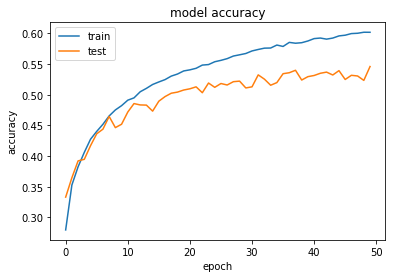

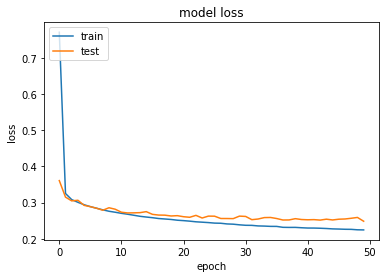

In [0]:
import matplotlib.pyplot as plt 
#accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()